In [1]:
import pandas as pd

# Load CSV files
df_attendance_marks = pd.read_csv("data_feie.csv")
df_schedule = pd.read_csv("prepared_schedule_data.csv")

# Step 1: Clean and prepare attendance/grades data
df_attendance_marks["nota_mitjana_asignatura"] = pd.to_numeric(
    df_attendance_marks["nota_mitjana_asignatura"], errors='coerce'
)
df_attendance_marks["attendance_rate"] = pd.to_numeric(
    df_attendance_marks["attendance_rate"], errors='coerce'
)
df_attendance_marks_clean = df_attendance_marks.dropna(
    subset=["nota_mitjana_asignatura", "attendance_rate"]
)

# Step 2: Correlation between attendance and grades
correlation = df_attendance_marks_clean[
    ["attendance_rate", "nota_mitjana_asignatura"]
].corr()
print("\n Correlation between Attendance and Grades:")
print(correlation)

# Step 3: Generate engagement score in schedule data
df_schedule['attendance_rate'] = pd.to_numeric(df_schedule['attendance_rate'], errors='coerce')
df_schedule['duration'] = pd.to_numeric(df_schedule['duration'], errors='coerce')

# Normalize
df_schedule['attendance_norm'] = (
    df_schedule['attendance_rate'] - df_schedule['attendance_rate'].min()
) / (
    df_schedule['attendance_rate'].max() - df_schedule['attendance_rate'].min()
)
df_schedule['duration_norm'] = (
    df_schedule['duration'] - df_schedule['duration'].min()
) / (
    df_schedule['duration'].max() - df_schedule['duration'].min()
)

# Engagement score (70% attendance + 30% duration)
df_schedule['engagement_score'] = 0.7 * df_schedule['attendance_norm'] + 0.3 * df_schedule['duration_norm']

# Step 4: Rank schedules by engagement score
df_schedule_ranked = df_schedule.sort_values(by='engagement_score', ascending=False)

# Step 5: Show top 10 time slots
print("\n Top 10 Ranked Schedule Slots:")
print(df_schedule_ranked[[
    'assignatura', 'day', 'hour', 'duration', 'attendance_rate', 'engagement_score'
]].head(10))



 Correlation between Attendance and Grades:
                         attendance_rate  nota_mitjana_asignatura
attendance_rate                 1.000000                 0.260228
nota_mitjana_asignatura         0.260228                 1.000000

 Top 10 Ranked Schedule Slots:
                  assignatura        day         hour  duration  \
110  Investigació Comercial I    dilluns        16-18       2.0   
111  Investigació Comercial I   dimecres  18.15-20.15       2.0   
64              Econometria I   dimecres         9-11       2.0   
65              Econometria I  divendres  11.15-13.15       2.0   
119   Direcció Estratègica II    dilluns  18.15-20.15       2.0   
118   Direcció Estratègica II  divendres        16-18       2.0   
30            Matemàtiques II    dilluns        16-18       2.0   
31            Matemàtiques II   dimecres  18.15-20.15       2.0   
103               Finances II     dijous  11.15-13.15       2.0   
102               Finances II    dimarts         9-11  

In [2]:
# Standardize 'assignatura' to lowercase
df_attendance_marks['assignatura'] = df_attendance_marks['assignatura'].str.lower()
df_schedule['assignatura'] = df_schedule['assignatura'].str.lower()

# Convert relevant columns to numeric
df_attendance_marks["nota_mitjana_asignatura"] = pd.to_numeric(df_attendance_marks["nota_mitjana_asignatura"], errors='coerce')
df_attendance_marks["attendance_rate"] = pd.to_numeric(df_attendance_marks["attendance_rate"], errors='coerce')
df_schedule["attendance_rate"] = pd.to_numeric(df_schedule["attendance_rate"], errors='coerce')
df_schedule["duration"] = pd.to_numeric(df_schedule["duration"], errors='coerce')

# Drop missing values
df_attendance_marks_clean = df_attendance_marks.dropna(subset=["nota_mitjana_asignatura", "attendance_rate"])

# Normalize grades and attendance
df_attendance_marks_clean['grade_norm'] = (
    df_attendance_marks_clean['nota_mitjana_asignatura'] - df_attendance_marks_clean['nota_mitjana_asignatura'].min()
) / (
    df_attendance_marks_clean['nota_mitjana_asignatura'].max() - df_attendance_marks_clean['nota_mitjana_asignatura'].min()
)

df_attendance_marks_clean['attendance_norm'] = (
    df_attendance_marks_clean['attendance_rate'] - df_attendance_marks_clean['attendance_rate'].min()
) / (
    df_attendance_marks_clean['attendance_rate'].max() - df_attendance_marks_clean['attendance_rate'].min()
)

# Compute performance score: 50% attendance + 50% grade
df_attendance_marks_clean['performance_score'] = 0.5 * df_attendance_marks_clean['grade_norm'] + 0.5 * df_attendance_marks_clean['attendance_norm']

# Aggregate average score by subject and time block
performance_by_schedule = df_attendance_marks_clean.groupby(['assignatura', 'horari'])['performance_score'].mean().reset_index()

# Map time_of_day to horari for schedule
def map_to_horari(tod):
    if 'morning' in tod:
        return 'mati'
    elif 'afternoon' in tod or 'evening' in tod:
        return 'tarda'
    return 'unknown'

df_schedule['time_of_day'] = df_schedule['time_of_day'].fillna('unknown')
df_schedule['horari'] = df_schedule['time_of_day'].apply(map_to_horari)

# Merge schedules with performance scores
df_schedule_performance = df_schedule.merge(performance_by_schedule, how='left', on=['assignatura', 'horari'])

# Rank by performance score
ranked_by_performance = df_schedule_performance.sort_values(by='performance_score', ascending=False)

# Display top 10 schedule slots
print("\n Top 10 Ranked Time Slots to Maximize Attendance & Marks:\n")
print(ranked_by_performance[['assignatura', 'day', 'hour', 'horari', 'performance_score']].head(10))



 Top 10 Ranked Time Slots to Maximize Attendance & Marks:

                  assignatura        day         hour horari  \
83                 finances i     dijous  11.15-13.15   mati   
82                 finances i    dimarts         9-11   mati   
110  investigació comercial i    dilluns        16-18  tarda   
111  investigació comercial i   dimecres  18.15-20.15  tarda   
7     economia de l'empresa i    dimarts  11.15-13.15   mati   
6     economia de l'empresa i     dijous         9-11   mati   
92                 finances i    dimarts        16-18  tarda   
93                 finances i     dijous  18.15-20.15  tarda   
119   direcció estratègica ii    dilluns  18.15-20.15  tarda   
118   direcció estratègica ii  divendres        16-18  tarda   

     performance_score  
83            0.809274  
82            0.809274  
110           0.798479  
111           0.798479  
7             0.735386  
6             0.735386  
92            0.699839  
93            0.699839  
119       

In [1]:
!apt-get install -y coinor-cbc
!pip install pulp

"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ------- -------------------------------- 2.9/16.4 MB 16.8 MB/s eta 0:00:01
   ---------------- ----------------------- 6.6/16.4 MB 17.5 MB/s eta 0:00:01
   ------------------------ --------------- 10.0/16.4 MB 17.2 MB/s eta 0:00:01
   -------------------------------- ------- 13.4/16.4 MB 16.4 MB/s eta 0:00:01
   ---------------------------------------  16.3/16.4 MB 16.5 MB/s eta 0:00:01
   ---------------------------------------- 16.4/16.4 MB 15.6 MB/s eta 0:00:00


In [3]:
import pulp                     # linear-programming toolkit
import pandas as pd

# ------------------------------------------------------------------
# 1. LOAD & PREPARE DATA
# ------------------------------------------------------------------
att = pd.read_csv("data_feie.csv")
sch = pd.read_csv("prepared_schedule_data.csv")

# Standardise subject names
att["assignatura"] = att["assignatura"].str.lower()
sch["assignatura"] = sch["assignatura"].str.lower()

# --------- build the PERFORMANCE SCORE ----------------------------
att["nota_mitjana_asignatura"] = pd.to_numeric(att["nota_mitjana_asignatura"],
                                               errors="coerce")
att["attendance_rate"]         = pd.to_numeric(att["attendance_rate"],
                                               errors="coerce")
att = att.dropna(
        subset=["nota_mitjana_asignatura", "attendance_rate"]
      )

att["grade_norm"] = (
    att["nota_mitjana_asignatura"] -
    att["nota_mitjana_asignatura"].min()
) / (
    att["nota_mitjana_asignatura"].max() -
    att["nota_mitjana_asignatura"].min()
)

att["att_norm"] = (
    att["attendance_rate"] - att["attendance_rate"].min()
) / (
    att["attendance_rate"].max() - att["attendance_rate"].min()
)

att["performance_score"] = 0.5*att["grade_norm"] + 0.5*att["att_norm"]

# Average the score for every combination (assignatura, horari)
perf_table = (att
              .groupby(["assignatura", "horari"])
              ["performance_score"]
              .mean()
              .reset_index())

# --------- map schedule rows to 'mati' / 'tarda' ------------------
def map_to_horari(tod: str) -> str:
    if isinstance(tod, str):
        if "morning"   in tod: return "mati"
        if "afternoon" in tod or "evening" in tod: return "tarda"
    return "unknown"

sch["horari"] = sch["time_of_day"].fillna("unknown").apply(map_to_horari)

# Merge the score into the schedule grid
sch = sch.merge(perf_table,
                how="left",
                on=["assignatura", "horari"])

# Missing = penalise with 0
sch["performance_score"] = sch["performance_score"].fillna(0.0)

# Convenience columns
sch["slot_id"]      = sch["day"] + "_" + sch["hour"]
sch["program_year"] = sch["grup_estudi"]                # proxy for cohort
sch["semester"]     = sch["semestre"]                   # already present

sch["course_key"] = (
    sch["assignatura"]
    + "_" + sch["semester"].astype(str)
    + "_" + sch["session_type"]               # (lecture / practical …)
)

# ------------------------------------------------------------------
# 2. BUILD THE OPTIMISATION MODEL
# ------------------------------------------------------------------
m = pulp.LpProblem("Schedule_Optimisation", pulp.LpMaximize)

# Decision variables: 1 = we keep that row in the final timetable
x = {
    idx: pulp.LpVariable(f"x_{idx}", 0, 1, cat="Binary")
    for idx in sch.index
}

# Objective: maximise total performance
m += pulp.lpSum(sch.loc[i, "performance_score"] * x[i] for i in sch.index)

# (a) exactly ONE slot per session of every course
for ck, rows in sch.groupby("course_key").groups.items():
    m += pulp.lpSum(x[i] for i in rows) == 1, f"one_slot_{ck}"

# (b) a cohort cannot be in two rooms at the same slot
for (cohort, slot), rows in sch.groupby(["program_year", "slot_id"]).groups.items():
    m += pulp.lpSum(x[i] for i in rows) <= 1, f"no_overlap_{cohort}_{slot}"

# ------------------------------------------------------------------
# 3. SOLVE
# ------------------------------------------------------------------
m.solve(pulp.PULP_CBC_CMD(msg=False))

# ------------------------------------------------------------------
# 4. OUTPUT THE OPTIMAL TIMETABLE
# ------------------------------------------------------------------
chosen = sch.loc[[i for i in sch.index if pulp.value(x[i]) == 1], [
        "program_year", "semester", "assignatura",
        "session_type", "day", "hour", "performance_score"
]].sort_values(["program_year", "semester", "day", "hour"])

print("\n=================  OPTIMAL SCHEDULE  =================\n")
print(chosen.to_string(index=False))

chosen.to_csv("optimal_schedule.csv", index=False)
print("\nSaved → optimal_schedule.csv")



=================  OPTIMAL SCHEDULE  =================

   program_year  semester                             assignatura session_type       day        hour  performance_score
 ADE - 1 - mati         1                                    dret    practical    dijous 11.15-14.15           0.000000
 ADE - 1 - mati         1                 economia de l'empresa i      lecture    dijous        9-11           0.735386
 ADE - 1 - mati         1                          matemàtiques i      lecture   dilluns        9-11           0.000000
 ADE - 1 - mati         1                 economia de l'empresa i    practical   dimarts 11.15-13.15           0.735386
 ADE - 1 - mati         1                                    dret      lecture   dimarts        9-11           0.000000
 ADE - 1 - mati         1                          matemàtiques i    practical  dimecres 11.15-13.15           0.000000
 ADE - 1 - mati         1                    hª econòmica mundial      lecture  dimecres        9-11   

In [9]:
import pandas as pd
from IPython.display import display

# Load the schedule saved by the optimizer
schedule = pd.read_csv("optimal_schedule.csv")

# Order of weekdays
day_order = ["dilluns", "dimarts", "dimecres", "dijous", "divendres"]

# Sort function for hour ranges
def hour_sort_key(h: str):
    start = h.split("-")[0].strip().replace(".", ":")
    try:
        return pd.to_datetime(start, format="%H:%M")
    except ValueError:
        return pd.to_datetime(start, format="%H")

# Create and show a visual timetable per program_year and semester
for (cohort, sem), df in schedule.groupby(["program_year", "semester"]):
    hour_index = sorted(df["hour"].unique(), key=hour_sort_key)

    pivot = (
        df.pivot(index="hour", columns="day", values="assignatura")
          .reindex(index=hour_index, columns=day_order)
          .fillna("")
    )

    print(f"\n📘 Schedule – {cohort} – Semester {sem}")
    display(pivot)



📘 Schedule – ADE - 1 - mati – Semester 1


day,dilluns,dimarts,dimecres,dijous,divendres
hour,,,,,
9-11,matemàtiques i,dret,hª econòmica mundial,economia de l'empresa i,introducció a l'economia
11.15-14.15,,,,dret,
11.15-13.15,,economia de l'empresa i,matemàtiques i,,hª econòmica mundial



📘 Schedule – ADE - 1 - tarda – Semester 1


day,dilluns,dimarts,dimecres,dijous,divendres
hour,,,,,
18.15-20.15,introducció a l'economia,,,,



📘 Schedule – ADE - 1 - tarda – Semester 2


day,dilluns,dimarts,dimecres,dijous,divendres
hour,,,,,
16-18,matemàtiques ii,introducció a la comptabilitat,economia internacional,estadística i,fonaments de màrqueting
18.15-20.15,,estadística i,matemàtiques ii,introducció a la comptabilitat,economia internacional



📘 Schedule – ADE - 2 - mati – Semester 1


day,dilluns,dimarts,dimecres,dijous,divendres
hour,,,,,
9-11,microeconomia i,comptabilitat de costos,economia espanyola,recursos humans,estadística ii
11.15-13.15,,recursos humans,microeconomia i,comptabilitat de costos,economia espanyola



📘 Schedule – ADE - 2 - tarda – Semester 2


day,dilluns,dimarts,dimecres,dijous,divendres
hour,,,,,
16-18,macroeconomia i,teories de l'empresa,,microeconomia ii,comptabilitat financera
18.15-20.15,comptabilitat financera,microeconomia ii,macroeconomia i,teories de l'empresa,econometria i



📘 Schedule – ADE - 3 - mati – Semester 1


day,dilluns,dimarts,dimecres,dijous,divendres
hour,,,,,
9-11,direcció estratègica i,finances i,direcció de màrqueting,investigació operativa,creació d'empreses
11.15-13.15,creació d'empreses,investigació operativa,direcció estratègica i,finances i,direcció de màrqueting



📘 Schedule – ADE - 3 - tarda – Semester 2


day,dilluns,dimarts,dimecres,dijous,divendres
hour,,,,,
16-18,,finances ii,direcció d'operacions,anàlisi i avaluació d'estats comptables,direcció estratègica ii
18.15-20.15,direcció estratègica ii,anàlisi i avaluació d'estats comptables,investigació comercial i,finances ii,direcció d'operacions


In [6]:
import pandas as pd
import pulp
from collections import defaultdict

# ----------------------
# Setup / Data Preparation
# ----------------------
df = pd.read_csv("prepared_schedule_data.csv")
group_name = "ADE - 1 - mati"
group_df = df[(df['grup_estudi'] == group_name) & (df['semestre'] == 2)].copy()

# Fill missing values
group_df['attendance_rate'] = group_df['attendance_rate'].fillna(group_df['attendance_rate'].median())
group_df['engagement_score'] = group_df['engagement_score'].fillna(group_df['engagement_score'].median())

# Define time slots
time_slots = [
    ('9:00', '11:00', 'early_morning'),
    ('11:15', '13:15', 'late_morning')
]

# Generate sessions – add a unique id for each row
sessions = []
for idx, row in group_df.iterrows():
    sessions.append({
        'id': idx,  # Unique identifier
        'subject': row['assignatura'],
        'type': row['session_type'],
        'required_slots': 1,
        'attendance': row['attendance_rate'],
        'area': row['area'],
        'original_day': row['day_code']
    })

# Define the optimization problem
prob = pulp.LpProblem("ADE1_Schedule_Optimization", pulp.LpMaximize)
days = [1, 2, 3, 4, 5]  # Monday to Friday

# Create decision variables using the session unique ID
choices = pulp.LpVariable.dicts(
    "assign",
    [(s['id'], s['subject'], s['type'], day, slot[0]) 
     for s in sessions for day in days for slot in time_slots],
    cat='Binary'
)

# Define weights
time_weights = {'early_morning': 1.5, 'late_morning': 1.2}
median_attendance = group_df['attendance_rate'].median()

# Objective function: prioritize pairing low with high attendance in early slots and group by area
prob += pulp.lpSum(
    choices[(s['id'], s['subject'], s['type'], day, slot[0])] * (
        time_weights[slot[2]] * (1.5 if s['attendance'] < median_attendance else 1.0)
    )
    for s in sessions 
    for day in days 
    for slot in time_slots
)

# Constraint: Each session scheduled exactly once
for s in sessions:
    prob += pulp.lpSum(
        choices[(s['id'], s['subject'], s['type'], day, slot[0])]
        for day in days for slot in time_slots
    ) == 1

# Constraint: No overlaps in time slots (max 1 subject per day & slot)
for day in days:
    for slot in time_slots:
        prob += pulp.lpSum(
            choices[(s['id'], s['subject'], s['type'], day, slot[0])]
            for s in sessions
        ) <= 1 

# Constraint: Group quantitative subjects on specific days (Monday:1 and Wednesday:3)
quant_subjects = ['Matemàtiques II', 'Estadística I']
for subj in quant_subjects:
    prob += pulp.lpSum(
        choices[(s['id'], s['subject'], s['type'], day, slot[0])]
        for s in sessions if s['subject'] == subj
        for day in [1, 3]
        for slot in time_slots
    ) >= 1

# Solve the problem
prob.solve()
print("Solver Status:", pulp.LpStatus[prob.status])

# Extract solution
schedule = []
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday'}

for (sid, subj, typ, day, start), var in choices.items():
    if pulp.value(var) == 1:
        end = next(slot[1] for slot in time_slots if slot[0] == start)
        # Retrieve attendance from the corresponding session
        att = next(s['attendance'] for s in sessions if s['id'] == sid)
        schedule.append({
            'Subject': subj,
            'Type': typ,
            'Day': day_names[day],
            'Start': start,
            'End': end,
            'Attendance Rate': att
        })

# Convert to DataFrame
optimized_df = pd.DataFrame(schedule)

# To avoid errors when sorting an empty DataFrame, check if the DataFrame is not empty.
if not optimized_df.empty:
    optimized_df = optimized_df.sort_values(['Day', 'Start'])

# Perform validation checks
duplicate_sessions = optimized_df.duplicated(subset=['Subject', 'Type']).sum() == 0
all_lectures_have_practicals = all(
    optimized_df[optimized_df['Type'] == 'lecture']['Subject'].isin(
        optimized_df[optimized_df['Type'] == 'practical']['Subject']
    )
)
no_time_conflicts = not any(
    optimized_df.duplicated(subset=['Day', 'Start'], keep=False)
)

print("\nValidation Results:")
print(f"Duplicate Sessions: {'No duplicates found' if duplicate_sessions else 'Duplicates exist'}")
print(f"All Lectures Have Practicals: {'Yes' if all_lectures_have_practicals else 'No'}")
print(f"No Time Conflicts: {'No conflicts found' if no_time_conflicts else 'Conflicts exist'}")
print("\nOptimized Schedule:")
print(optimized_df.to_string(index=False))

Solver Status: Optimal

Validation Results:
Duplicate Sessions: Duplicates exist
All Lectures Have Practicals: No
No Time Conflicts: No conflicts found

Optimized Schedule:
                       Subject      Type       Day Start   End  Attendance Rate
Introducció a la Comptabilitat practical    Friday 11:15 13:15         0.615385
                 Estadística I practical    Friday  9:00 11:00         0.615385
                 Estadística I   lecture    Monday 11:15 13:15         0.615385
        Economia Internacional   lecture    Monday  9:00 11:00         0.520833
               Matemàtiques II   lecture  Thursday 11:15 13:15         0.673333
       Fonaments de Màrqueting   lecture  Thursday  9:00 11:00         0.615385
       Fonaments de Màrqueting   lecture   Tuesday 11:15 13:15         0.615385
Introducció a la Comptabilitat   lecture   Tuesday  9:00 11:00         0.615385
               Matemàtiques II practical Wednesday 11:15 13:15         0.673333
        Economia Internacio

Final Model
=======================

In [ ]:
import pandas as pd
import pulp
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import numpy as np

# ----------------------
# Data Preparation
# ----------------------
# Load the full dataset
df = pd.read_csv("prepared_schedule_data.csv")

# Process all groups
all_groups = df['grup_estudi'].unique()
all_semesters = df['semestre'].unique()

# Initialize storage for all schedules
all_schedules = []

for group_name in all_groups:
    for semester in all_semesters:
        group_df = df[(df['grup_estudi'] == group_name) & (df['semestre'] == semester)].copy()
        
        if len(group_df) == 0:
            continue
            
        # Fill missing values
        group_df['attendance_rate'] = group_df['attendance_rate'].fillna(group_df['attendance_rate'].median())
        group_df['engagement_score'] = group_df['engagement_score'].fillna(group_df['engagement_score'].median())


        # Define time slots based on group (morning/afternoon)
        if 'mati' in group_name:
            time_slots = [
                ('9:00', '11:00', 'early_morning'),
                ('11:15', '13:15', 'late_morning')
            ]
        else:
            time_slots = [
                ('16:00', '18:00', 'afternoon'),
                ('18:15', '20:15', 'evening')
            ]

        # Create session list with unique IDs
        sessions = []
        for idx, row in group_df.iterrows():
            sessions.append({
                'id': f"{row['assignatura']}_{row['session_type']}_{idx}",
                'subject': row['assignatura'],
                'type': row['session_type'],
                'attendance': row['attendance_rate'],
                'area': row['area'],
                'original_day': row['day_code'],
                'group': group_name,
                'semester': semester
            })

        # ----------------------
        # Optimization Problem Setup
        # ----------------------
        prob = pulp.LpProblem(f"Schedule_Optimization_{group_name}_Sem{semester}", pulp.LpMaximize)
        days = [1, 2, 3, 4, 5]  # Monday to Friday

        # Create decision variables
        choices = pulp.LpVariable.dicts(
            "assign",
            [(s['id'], s['subject'], s['type'], day, slot[0])
             for s in sessions for day in days for slot in time_slots],
            cat='Binary'
        )

        # Define weights
        time_weights = {
            'early_morning': 1.5, 
            'late_morning': 1.2,
            'afternoon': 1.2,
            'evening': 1.0
        }
        median_attendance = group_df['attendance_rate'].median()

        # Base objective function
        original_obj = pulp.lpSum(
            choices[(s['id'], s['subject'], s['type'], day, slot[0])] * (
                time_weights[slot[2]] * (1.5 if s['attendance'] < median_attendance else 1.0)
            )
            for s in sessions for day in days for slot in time_slots
        )

        # ----------------------
        # Additional Objectives
        # ----------------------
        # Grouping bonus/penalty
        related_bonus = 0.5
        different_penalty = 0.2
        
        y_vars = {}
        for i in range(len(sessions)):
            for j in range(i+1, len(sessions)):
                for d in days:
                    y_vars[(sessions[i]['id'], sessions[j]['id'], d)] = pulp.LpVariable(
                        f"y_{sessions[i]['id']}_{sessions[j]['id']}_{d}", cat='Binary'
                    )

        day_assign = {}
        for s in sessions:
            for d in days:
                day_assign[(s['id'], d)] = pulp.lpSum(
                    choices[(s['id'], s['subject'], s['type'], d, slot[0])]
                    for slot in time_slots
                )

        for i in range(len(sessions)):
            for j in range(i+1, len(sessions)):
                for d in days:
                    sid_i = sessions[i]['id']
                    sid_j = sessions[j]['id']
                    prob += y_vars[(sid_i, sid_j, d)] <= day_assign[(sid_i, d)]
                    prob += y_vars[(sid_i, sid_j, d)] <= day_assign[(sid_j, d)]
                    prob += y_vars[(sid_i, sid_j, d)] >= day_assign[(sid_i, d)] + day_assign[(sid_j, d)] - 1

        pair_bonus_term = []
        for i in range(len(sessions)):
            for j in range(i+1, len(sessions)):
                for d in days:
                    if sessions[i]['subject'] == sessions[j]['subject']:
                        pair_bonus_term.append(0)
                    else:
                        if sessions[i]['area'] == sessions[j]['area']:
                            pair_bonus_term.append(related_bonus * y_vars[(sessions[i]['id'], sessions[j]['id'], d)])
                        else:
                            pair_bonus_term.append(- different_penalty * y_vars[(sessions[i]['id'], sessions[j]['id'], d)])

        # Lecture before practical bonus
        beta = 1.0
        subject_types = defaultdict(set)
        for s in sessions:
            subject_types[s['subject']].add(s['type'])
        subjects_with_both = [subj for subj, types in subject_types.items() if 'lecture' in types and 'practical' in types]

        scheduling_order_bonus_terms = []
        for subj in subjects_with_both:
            lecture_day_expr = pulp.lpSum(
                d * choices[(s['id'], s['subject'], s['type'], d, slot[0])]
                for s in sessions if s['subject'] == subj and s['type'] == 'lecture'
                for d in days for slot in time_slots
            )
            practical_day_expr = pulp.lpSum(
                d * choices[(s['id'], s['subject'], s['type'], d, slot[0])]
                for s in sessions if s['subject'] == subj and s['type'] == 'practical'
                for d in days for slot in time_slots
            )
            scheduling_order_bonus_terms.append(beta * (practical_day_expr - lecture_day_expr))

        # Final objective
        prob += original_obj + pulp.lpSum(pair_bonus_term) + pulp.lpSum(scheduling_order_bonus_terms)

        # ----------------------
        # Constraints
        # ----------------------
        for s in sessions:
            prob += pulp.lpSum(
                choices[(s['id'], s['subject'], s['type'], day, slot[0])]
                for day in days for slot in time_slots
            ) == 1

        for day in days:
            for slot in time_slots:
                prob += pulp.lpSum(
                    choices[(s['id'], s['subject'], s['type'], day, slot[0])]
                    for s in sessions
                ) <= 1

        # ----------------------
        # Solve and Store Results
        # ----------------------
        prob.solve()
        
        day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday'}
        
        for (sid, subj, typ, day, start), var in choices.items():
            if pulp.value(var) == 1:
                end = next(slot[1] for slot in time_slots if slot[0] == start)
                att = next(s['attendance'] for s in sessions if s['id'] == sid)
                all_schedules.append({
                    'Group': group_name,
                    'Semester': semester,
                    'Subject': subj,
                    'Type': typ,
                    'Day': day_names[day],
                    'DayCode': day,
                    'Start': start,
                    'End': end,
                    'TimeOfDay': next(slot[2] for slot in time_slots if slot[0] == start),
                    'Attendance': att
                })

# Combine all schedules
full_schedule = pd.DataFrame(all_schedules)

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pulp\pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pulp\pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pulp\pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\

In [8]:
# save the full schedule to a CSV file
full_schedule.to_csv("full_optimized_schedule.csv", index=False)

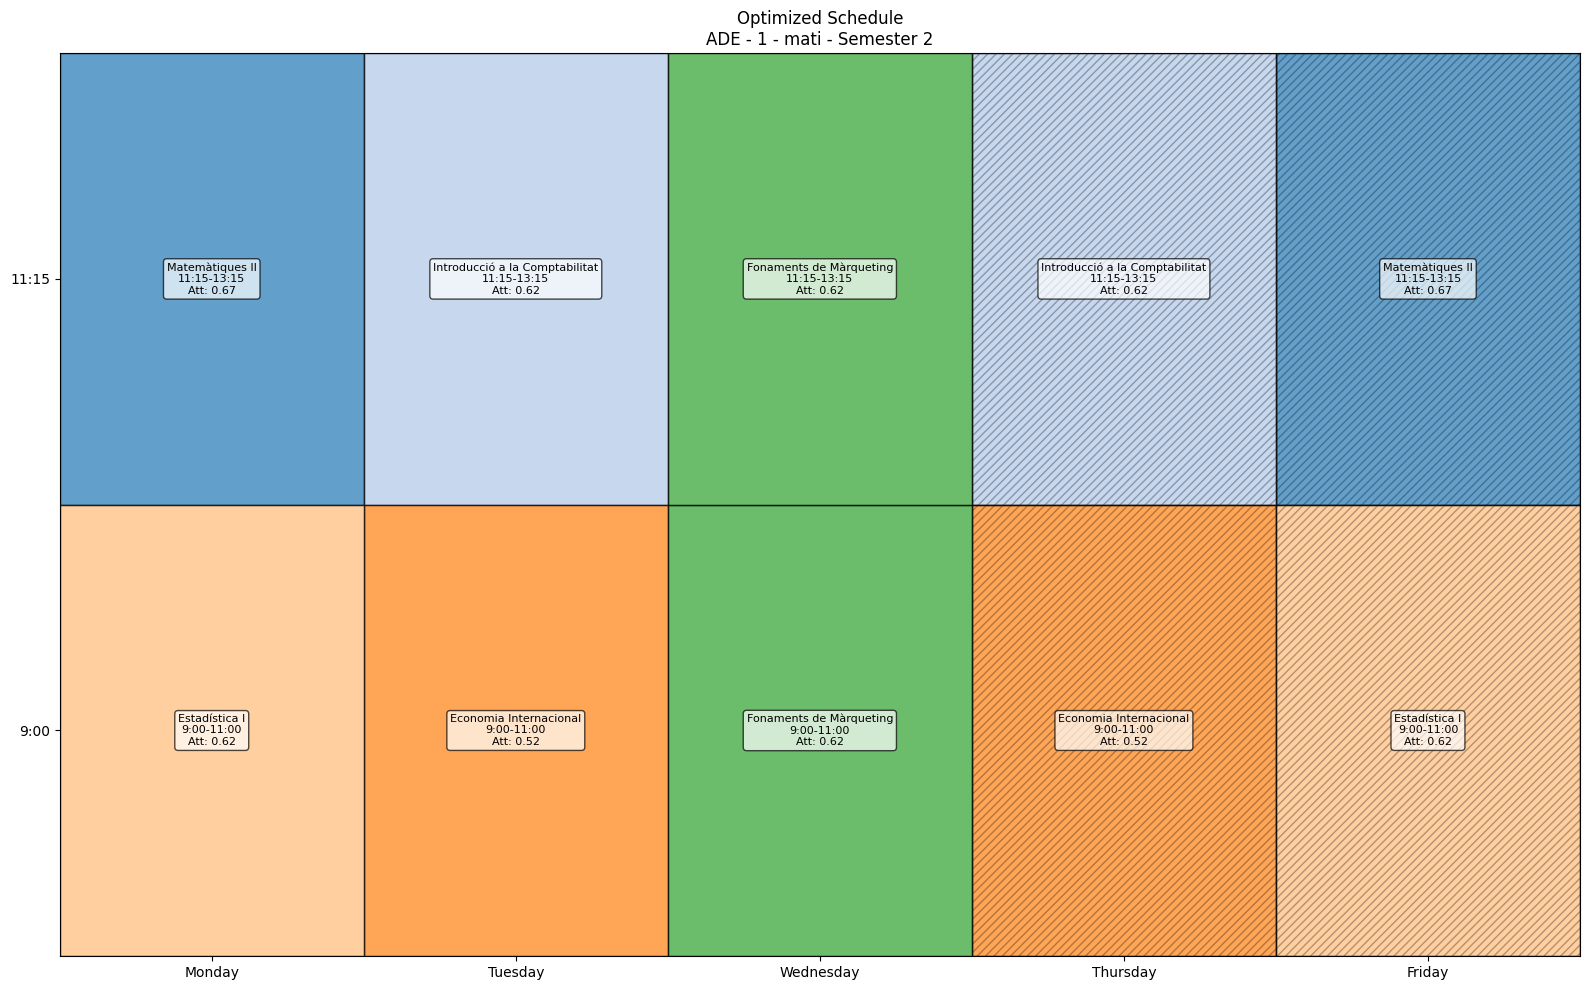

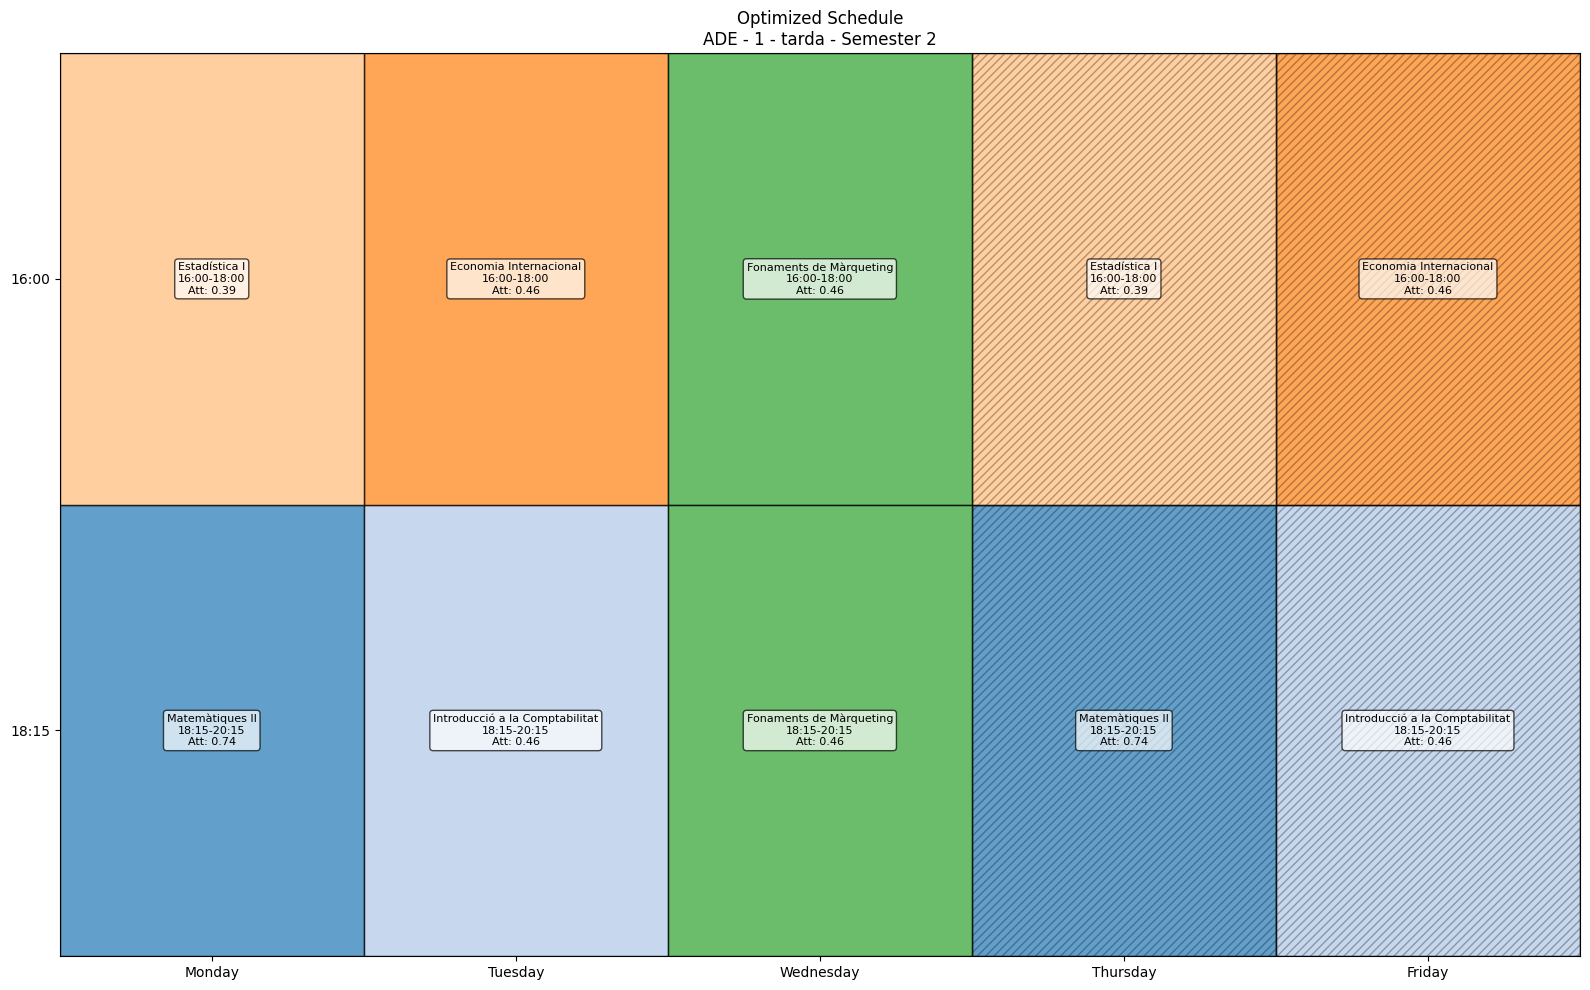

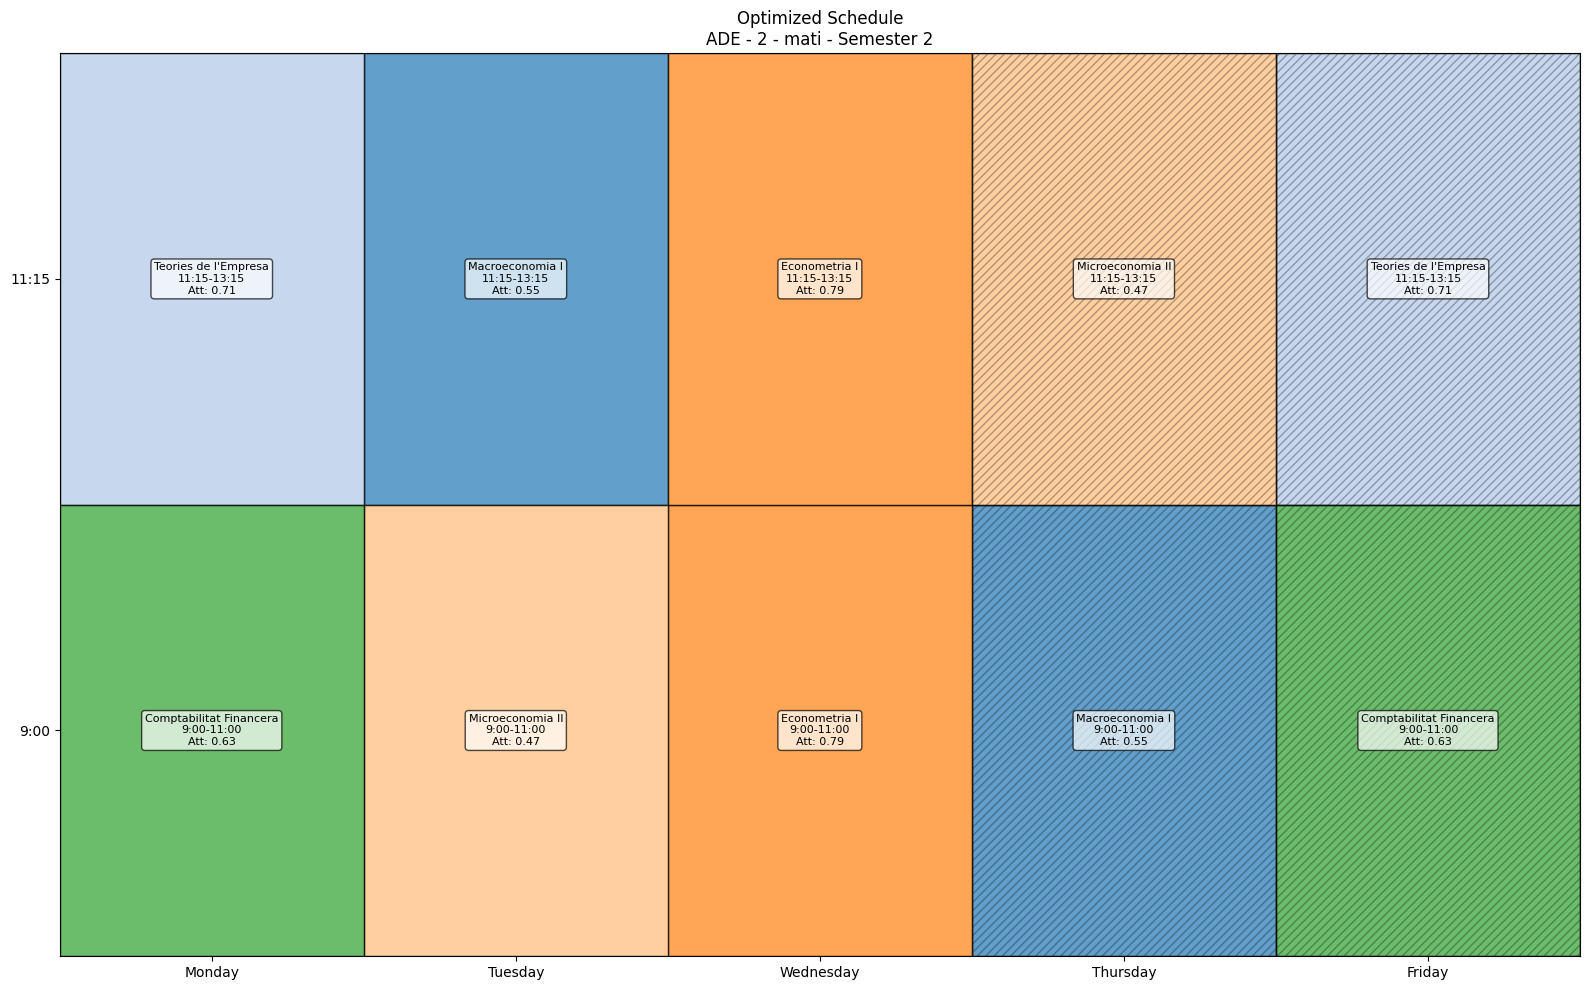

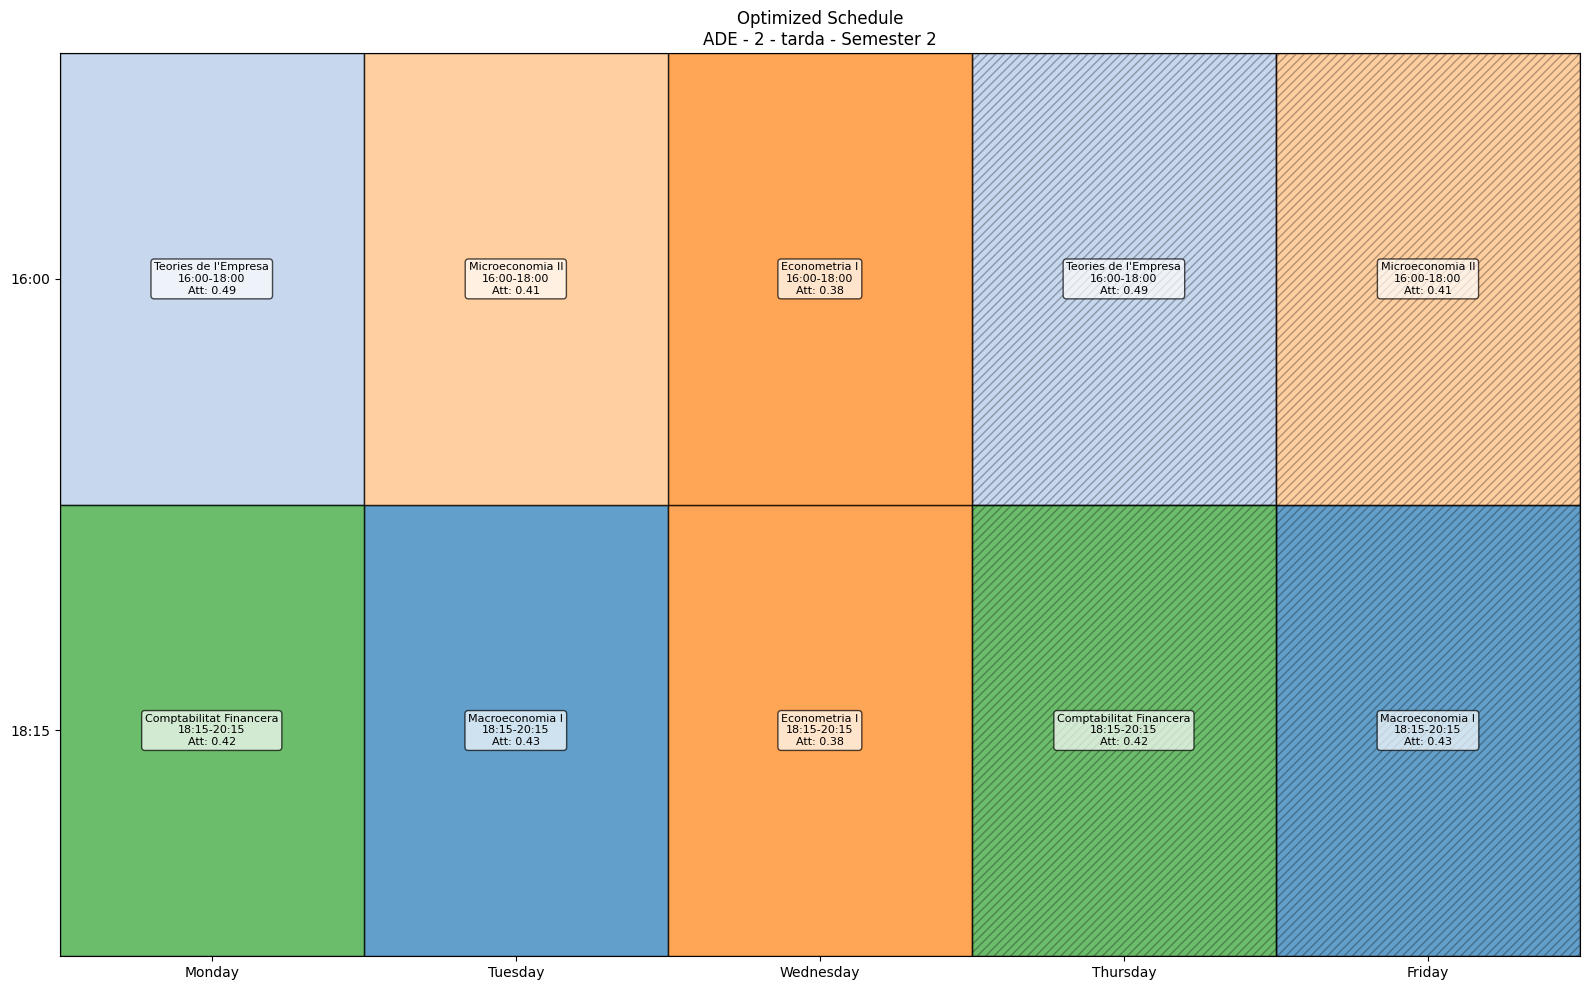

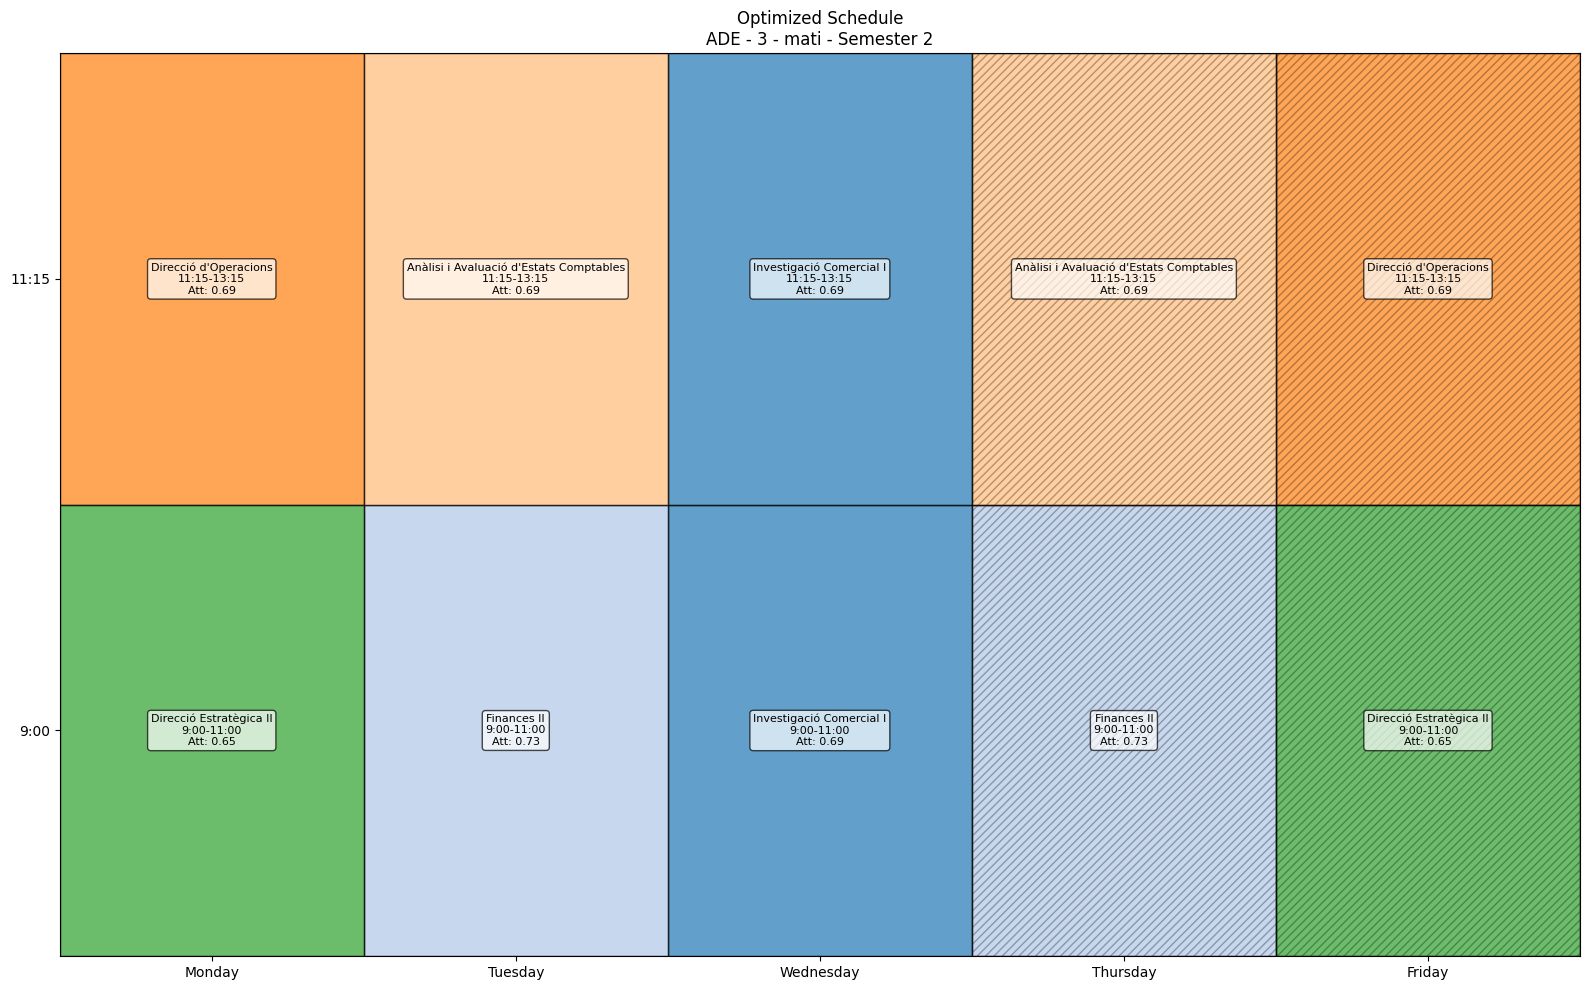

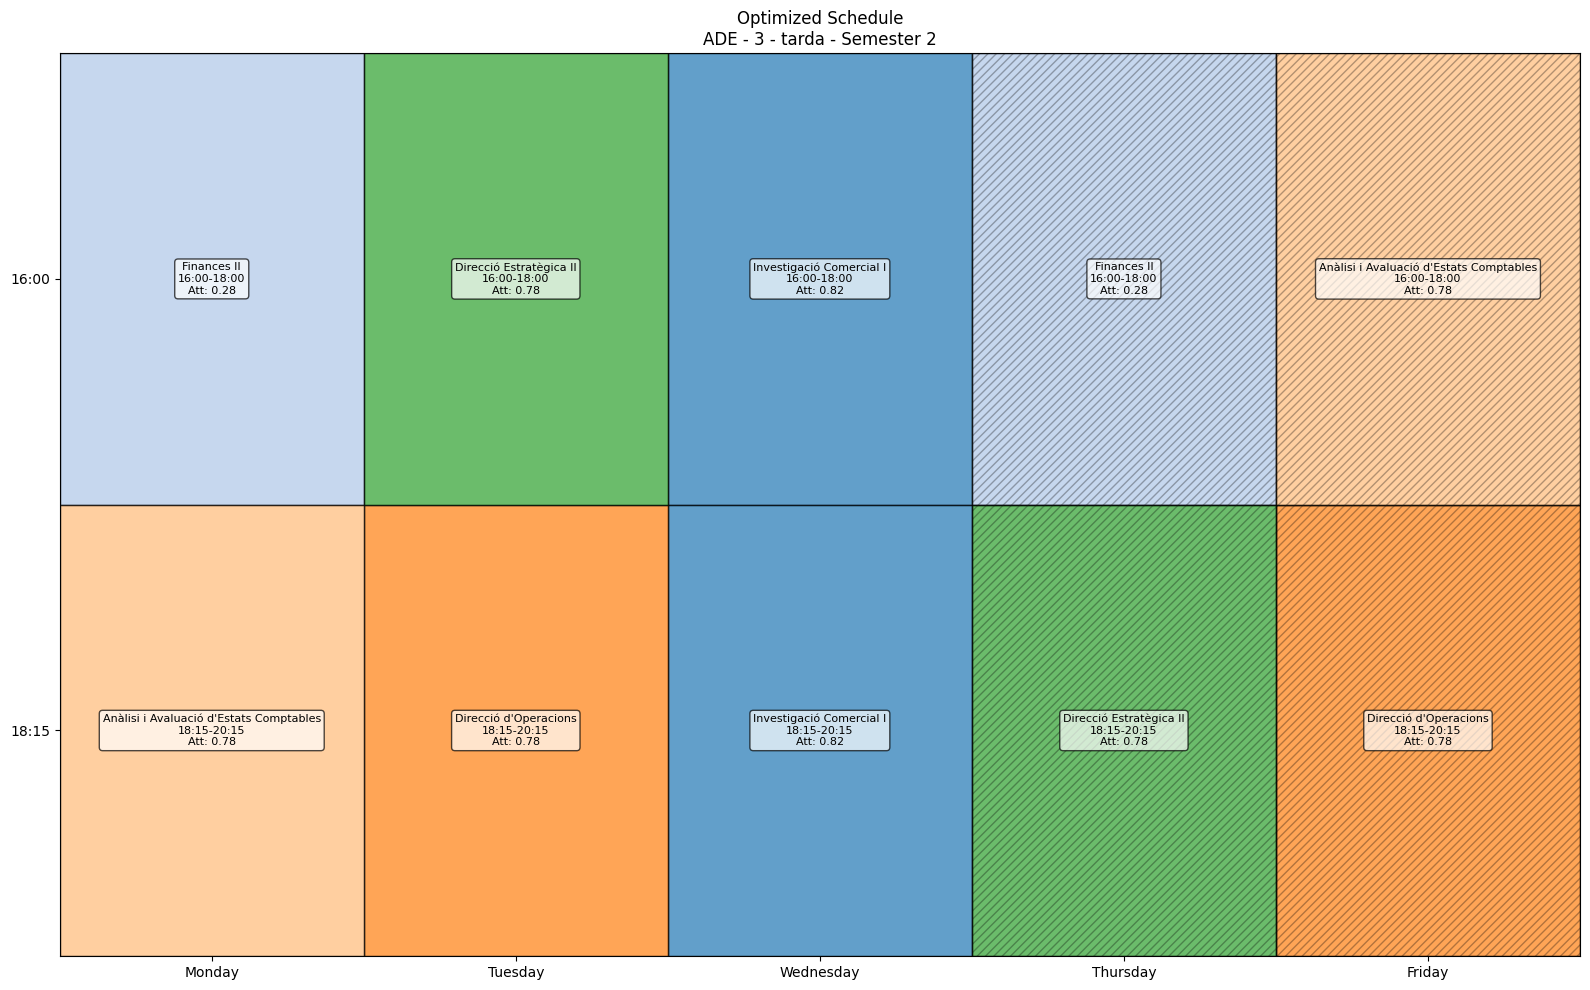

Optimization Complete!
Total sessions scheduled: 60
Groups processed: 6
Semesters processed: 1


In [9]:
def visualize_full_schedule(schedule_df):
    # Create a figure for each group and semester
    for (group, semester), group_schedule in schedule_df.groupby(['Group', 'Semester']):
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Get unique subjects and assign colors
        subjects = group_schedule['Subject'].unique()
        colors = plt.cm.tab20.colors
        subject_colors = {subj: colors[i % len(colors)] for i, subj in enumerate(subjects)}
        
        # Day and time setup
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        times = sorted(group_schedule['Start'].unique())
        
        # Create grid
        for day in days:
            for time in times:
                ax.add_patch(patches.Rectangle(
                    (days.index(day)-0.5, times.index(time)-0.5), 
                    1, 1, 
                    fill=False, 
                    edgecolor='lightgray', 
                    lw=1
                ))
        
        # Plot each session
        for _, row in group_schedule.iterrows():
            day_idx = days.index(row['Day'])
            time_idx = times.index(row['Start'])
            
            # Main rectangle
            rect = patches.Rectangle(
                (day_idx-0.5, time_idx-0.5), 
                1, 1,
                facecolor=subject_colors[row['Subject']],
                alpha=0.7,
                edgecolor='black',
                lw=1
            )
            ax.add_patch(rect)
            
            # Pattern for practical sessions
            if row['Type'] == 'practical':
                pattern = patches.Rectangle(
                    (day_idx-0.5, time_idx-0.5), 
                    1, 1,
                    fill=False,
                    hatch='////',
                    edgecolor='black',
                    alpha=0.3,
                    lw=1
                )
                ax.add_patch(pattern)
            
            # Text label
            ax.text(
                day_idx, time_idx,
                f"{row['Subject']}\n{row['Start']}-{row['End']}\nAtt: {row['Attendance']:.2f}",
                ha='center', va='center',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
            )
        
        # Customize axes
        ax.set_xticks(range(len(days)))
        ax.set_xticklabels(days)
        ax.set_yticks(range(len(times)))
        ax.set_yticklabels(times)
        ax.set_xlim(-0.5, len(days)-0.5)
        ax.set_ylim(-0.5, len(times)-0.5)
        ax.invert_yaxis()
        
        # Create legends
        legend_patches = [
            patches.Patch(color=subject_colors[subj], label=subj)
            for subj in subjects
        ]
        ax.legend(
            handles=legend_patches, 
            bbox_to_anchor=(1.15, 1), 
            loc='upper left',
            title='Subjects'
        )
        
        type_patches = [
            patches.Patch(facecolor='white', edgecolor='black', label='Lecture'),
            patches.Patch(facecolor='white', edgecolor='black', hatch='////', label='Practical')
        ]
        ax.legend(
            handles=type_patches, 
            bbox_to_anchor=(1.15, 0.7), 
            loc='upper left',
            title='Session Types'
        )
        
        # Add first legend back (second legend overwrites it)
        ax.add_artist(ax.legend(handles=legend_patches, bbox_to_anchor=(1.15, 1), loc='upper left', title='Subjects'))
        
        plt.title(f'Optimized Schedule\n{group} - Semester {semester}')
        plt.tight_layout()
        plt.show()

# Generate visualizations
visualize_full_schedule(full_schedule)

# Save full schedule to CSV
full_schedule.to_csv('optimized_schedules_all_groups.csv', index=False)

# Print summary
print("Optimization Complete!")
print(f"Total sessions scheduled: {len(full_schedule)}")
print(f"Groups processed: {len(full_schedule['Group'].unique())}")
print(f"Semesters processed: {len(full_schedule['Semester'].unique())}")